<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-del-projecto-cad_kbcm_jfl/blob/main/Reto_Entrega_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instituto Tecnológico de Estudios Superiores de Monterrey**

**Maestría en Inteligencia Artificial Aplicada**

**Ciencia y Analítica de datos**

**Nombre del trabajo:** Reto -> Entrega 2: Clasificación y ensambles

**Nombre del maestro:** María de la Paz Rico Fernández

**Nombre de los estudiantes:** Kevin Brandon Cruz Jorge Fernández Lara

**Matrículas:** A01794176 A01793062

**Fecha de entrega:** 18 de noviembre de 2022

In [3]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 483 kB/s 
     |████████████████████████████████| 1.0 MB 51.0 MB/s 
     |████████████████████████████████| 1.7 MB 39.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 48.8 MB/s 
     |████████████████████████████████| 6.3 MB 55.5 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27812 sha256=9894119d0ab4d10163fbe8d96ca6499356862793e0ba42cfb13f9229a9513c30
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=164966ad49ad7bb86311c3182f4f37d439e8be91f418a5d821b68b743e749951
  Stored in directory: /root/.

In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import tqdm
%matplotlib inline
import geopandas as gpd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();
from sklearn.cluster import KMeans

from statistics import mode

In [5]:
#Como hemos estado trabajando con las aguas superficiales, se vuelve a importar el mismo conjunto de datos

filename = 'https://raw.githubusercontent.com/PosgradoMNA/actividades-del-projecto-cad_kbcm_jfl/main/Reto/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020.csv'
df = pd.read_csv(filename, encoding='cp1252')
df.head()



,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,...,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,PRESA EL SAUCILLO 100M AGUAS ARRIBA DE LA CORTINA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,RIO SAN PEDRO,PRESA EL SAUCILLO,LENTICO,PRESA,-102.33911,...,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,"LOS CABOS SEG 22, 2 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN JOSE DEL CABO,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.84290,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,"LOS CABOS SEG 22, 1 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.86442,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,LOS CABOS 3,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.88604,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
4,DLBAJ103,LOS CABOS 1,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.89657,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


Vamos a separar las variables dependientes (X) de las independientes (Y).

Como nuestra variable dependiente o de salida corresponde a la de la calidad del agua, es la de "SEMAFORO".

In [6]:
df1 = df.copy()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4141 entries, 0 to 4140
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLAVE                   3493 non-null   object 
 1   SITIO                   3493 non-null   object 
 2   ORGANISMO_DE_CUENCA     3493 non-null   object 
 3   ESTADO                  3493 non-null   object 
 4   MUNICIPIO               3493 non-null   object 
 5   CUENCA                  3492 non-null   object 
 6   CUERPO DE AGUA          3479 non-null   object 
 7   TIPO                    3493 non-null   object 
 8   SUBTIPO                 3479 non-null   object 
 9   LONGITUD                3493 non-null   float64
 10  LATITUD                 3493 non-null   float64
 11  PERIODO                 3493 non-null   float64
 12  DBO_mg/L                2581 non-null   object 
 13  CALIDAD_DBO             2581 non-null   object 
 14  DQO_mg/L                2581 non-null   

El número de registros de la variable de salida 'SEMAFORO' es menor a los registros totales, por lo que se presume que si son 4141 registros y existen 3493, 648 registros de 'SEMAFORO' son NaN, que procederemos a eliminar.

In [7]:
df1.isna().sum()

CLAVE                      648
SITIO                      648
ORGANISMO_DE_CUENCA        648
ESTADO                     648
MUNICIPIO                  648
CUENCA                     649
CUERPO DE AGUA             662
TIPO                       648
SUBTIPO                    662
LONGITUD                   648
LATITUD                    648
PERIODO                    648
DBO_mg/L                  1560
CALIDAD_DBO               1560
DQO_mg/L                  1560
CALIDAD_DQO               1560
SST_mg/L                   652
CALIDAD_SST                652
COLI_FEC_NMP_100mL        1559
CALIDAD_COLI_FEC          1559
E_COLI_NMP_100mL          1559
CALIDAD_E_COLI            1559
ENTEROC_NMP_100mL         3237
CALIDAD_ENTEROC           3237
OD_PORC                   2344
CALIDAD_OD_PORC           2344
OD_PORC_SUP               2522
CALIDAD_OD_PORC_SUP       2522
OD_PORC_MED               3654
CALIDAD_OD_PORC_MED       3654
OD_PORC_FON               3195
CALIDAD_OD_PORC_FON       3195
TOX_D_48

In [8]:
df1 = df1.dropna(how = 'all')
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 0 to 3492
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLAVE                   3493 non-null   object 
 1   SITIO                   3493 non-null   object 
 2   ORGANISMO_DE_CUENCA     3493 non-null   object 
 3   ESTADO                  3493 non-null   object 
 4   MUNICIPIO               3493 non-null   object 
 5   CUENCA                  3492 non-null   object 
 6   CUERPO DE AGUA          3479 non-null   object 
 7   TIPO                    3493 non-null   object 
 8   SUBTIPO                 3479 non-null   object 
 9   LONGITUD                3493 non-null   float64
 10  LATITUD                 3493 non-null   float64
 11  PERIODO                 3493 non-null   float64
 12  DBO_mg/L                2581 non-null   object 
 13  CALIDAD_DBO             2581 non-null   object 
 14  DQO_mg/L                2581 non-null   

Las variables TOX_D_48_FON_UT , CALIDAD_TOX_D_48_FON ,  TOX_FIS_FON_15_UT y CALIDAD_TOX_FIS_FON_15 están vacías por las que se eliminarán.

In [9]:
vacias = ['TOX_D_48_FON_UT','CALIDAD_TOX_D_48_FON','TOX_FIS_FON_15_UT','CALIDAD_TOX_FIS_FON_15']
df1.drop(vacias, inplace = True, axis =1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 0 to 3492
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLAVE                   3493 non-null   object 
 1   SITIO                   3493 non-null   object 
 2   ORGANISMO_DE_CUENCA     3493 non-null   object 
 3   ESTADO                  3493 non-null   object 
 4   MUNICIPIO               3493 non-null   object 
 5   CUENCA                  3492 non-null   object 
 6   CUERPO DE AGUA          3479 non-null   object 
 7   TIPO                    3493 non-null   object 
 8   SUBTIPO                 3479 non-null   object 
 9   LONGITUD                3493 non-null   float64
 10  LATITUD                 3493 non-null   float64
 11  PERIODO                 3493 non-null   float64
 12  DBO_mg/L                2581 non-null   object 
 13  CALIDAD_DBO             2581 non-null   object 
 14  DQO_mg/L                2581 non-null   

Dónde:

0. **CLAVE:** es categórico Identificador del registro
1. **SITIO:** es categórica sobre ubicación
2. **ORGANISMO_DE_CUENCA:** categórica que identifica al responsable de administrar y preservar las aguas nacionales en cada una de las trece regiones hidrológico-administrativas en que se ha dividido el país
3. **ESTADO:** categórica sobre el estado en que está ubicado el sitio de muestreo
4. **MUNICIPIO:** categórica sobre el municipio en que está ubicado el sitio de muestreo
5. **CUENCA:** categórica sobre el nombre de la cuenca donde se localiza el sitio de monitoreo
6. **CUERPO DE AGUA:** categórica sobre el nombre del cuerpo de agua donde se localiza el sitio de monitoreo
7. **TIPO:** Categórica sobre el tipo de cuerpo de agua donde se encuentra el sitio de muestreo
8. **SUBTIPO:** Categórica sobre el subtipo de cuerpo de agua donde se encuentra el sitio de muestreo 
9. **LONGITUD:** numérica longitud
10. **LATITUD:** numérica latitud
11. **PERIODO:** categórica Año en que se realizo el muestreo
12. **DBO_mg/L:** numérica Valor de la Demanda Bioquimica de Oxigeno, en miligramos por litro
13. **CALIDAD_DBO:** categórica Clasificacion de la calidad del agua de acuerdo con el indicador Demanda Bioquimica de Oxigeno
14. **DQO_mg/L:** numérica Valor de la Demanda Quimica de Oxigeno, en miligramos por litro
15. **CALIDAD_DQO:** categórica Clasificacion de la calidad del agua de acuerdo con el indicador Demanda Quimica de Oxigeno
16. **SST_mg/L:** numérica Valor de los Solidos Suspendidos Totales, en miligramos por litro
17. **CALIDAD_SST:** categórica Clasificacion de la calidad del agua de acuerdo con el indicador Solidos Suspendidos Totales
18. **COLI_FEC_NMP_100mL:** numérica Valor de los Coliformes Fecales, en numero mas probable por cien mililitros
19. **CALIDAD_COLI_FEC:** categórica Clasificacion de la calidad del agua de acuerdo con el indicador Coliformes Fecales
20. **E_COLI_NMP_100mL:** numérica Valor de Escherichia coli, en numero mas probable por cien mililitros
21. **CALIDAD_E_COLI:** categórica Clasificacion de la calidad del agua de acuerdo con el indicador Escherichia coli
22. **ENTEROC_NMP_100mL:** numérica Valor de Enterococos fecales, en numero mas probable por cien mililitros
23. **CALIDAD_ENTEROC:** categórica Indica si cumple con la calidad de Excelente o Buena calidad, para el Indicador Enterococos fecales
24. **OD_PORC:** numérica Valor de Porcentaje de saturacion de oxigeno disuelto, en cuerpos loticos
25. **CALIDAD_OD_PORC:** categórica de saturación de oxígeno
26. **OD_PORC_SUP:** numérica Valor de Porcentaje de saturacion de oxigeno disuelto superficial
27. **CALIDAD_OD_PORC_SUP:** categórica Clasificacion de la calidad del agua de acuerdo con el indicador Porcentaje de saturaci¢n de Oxigeno disuelto, superficial
28. **OD_PORC_MED:** numérica Valor de Porcentaje de saturacion de oxigeno disuelto medio
29. **CALIDAD_OD_PORC_MED:** categórica Clasificacion de la calidad del agua de acuerdo con el indicador Porcentaje de saturacion de oxigeno disuelto, medio
30. **OD_PORC_FON:** numérica Valor de Porcentaje de saturacion de oxigeno disuelto en fondo
31. **CALIDAD_OD_PORC_FON:** categórica Clasificacion de la calidad del agua de acuerdo con el indicador Porcentaje de saturacion de oxigeno disuelto, en fondo
32. **TOX_D_48_UT:** numérica Valor de Toxicidad, Dafnia magna, 48 horas, Unidades de Toxicidad, en cuerpos loticos
33. **CALIDAD_TOX_D_48:** categórica Clasificacion de la calidad del agua de acuerdo con el indicador Toxicidad, Dafnia magna, 48 horas
34. **TOX_V_15_UT:** numérica Valor de Toxicidad, Vibrio Fisheri, 15 minutos, Unidades de Toxicidad, en cuerpos loticos
35. **CALIDAD_TOX_V_15:** categórica Clasificacion de la calidad del agua de acuerdo con el indicador Toxicidad, Vibrio Fisheri, 15 minutos
36. **TOX_D_48_SUP_UT:** numérica Valor de Toxicidad, Dafnia magna 48 horas, superficial, Unidades de Toxicidad
37. **CALIDAD TOX_D_48_SUP:** categórica Clasificacion de la calidad del agua de acuerdo con el indicador de Toxicidad, Dafnia magna 48 horas, superficial
38. **TOX_D_48_FON_UT:** numérica Valor de Toxicidad, Dafnia magna, 48 horas, Unidades de Toxicidad, en cuerpos loticos
39. **CALIDAD_TOX_D_48_FON:** categórica Clasificacion de la calidad del agua de acuerdo con el indicador, Toxicidad, Dafnia magna 48 horas, en fondo
40. **TOX_FIS_SUP_15_UT:** numérica Valor de Toxicidad, Vibrio Fisheri, 15 minutos, superficial, Unidades de Toxicidad
41. **CALIDAD_TOX_FIS_SUP_15:** categórica Clasificacion de la calidad del agua de acuerdo con el indicador de Toxicidad, Vibrio Fisheri, 15 minutos, superficial
42. **TOX_FIS_FON_15_UT:** numérica Valor de Toxicidad, Vibrio Fisheri, 15 minutos, en fondo, Unidades de Toxicidad
43. **CALIDAD_TOX_FIS_FON_15:** categórica Clasificacion de la calidad del agua de acuerdo con el indicador Toxicidad, Vibrio Fisheri, 15 minutos, en fondo
44. **SEMAFORO:** categórica Indica el nivel de contaminacion de acuerdo a los contaminantes presentes
45. **CONTAMINANTES:** string Contaminantes  presentes en incumplimiento (Contaminados).
46. **CUMPLE_CON_DBO:** binaria sobre si cumple criterio de Indica si cumple con la calidad de Excelente, Buena calidad o Aceptable, para el Indicador Demanda Bioquimica de Oxigeno
47. **CUMPLE_CON_DQO:** binaria sobre si cumple criterio de Indica si cumple con la calidad de Excelente, Buena calidad o Aceptable, para el Indicador Demanda Quimica de Oxigeno
48. **CUMPLE_CON_SST:** binaria sobre si cumple criterio de Indica si cumple con la calidad de Excelente, Buena calidad o Aceptable, para el Indicador Solidos Suspendidos Totales
49. **CUMPLE_CON_CF:** binaria sobre si cumple criterio de Indica si cumple con la calidad de Excelente, Buena calidad o Aceptable, para el Indicador Coliformes Fecales
50. **CUMPLE_CON_E_COLI:** binaria sobre si cumple criterio de Indica si cumple con la calidad de Excelente, Buena calidad o Aceptable, para el Indicador Escherichia coli
51. **CUMPLE_CON_ENTEROC:** binaria sobre si cumple criterio de Indica si cumple con la calidad de Excelente o Buena calidad, para el Indicador Enterococos fecales
52. **CUMPLE_CON_OD:** binaria sobre si cumple criterio de Indica si cumple con la calidad de Excelente, Buena calidad o Aceptable, para el Indicador Porcentaje de saturaci¢n de Oxigeno disuelto
53. **CUMPLE_CON_TOX:** binaria sobre si cumple criterio de Indica si cumple con la calidad de No toxico, Toxicidad baja, o Toxicidad moderada, para el Indicador Toxicidad aguda
54. **GRUPO:** categórico Grupo del cuerpo de agua

Con base en la definición de cada atributo, no nos son de utilidad algunos para el desarrollo del modelo, como lo son:

* Clave
* Sitio
* ORGANISMO_DE_CUENCA
* ESTADO
* MUNICIPIO
* CUENCA
* CUERPO DE AGUA
* TIPO
* SUBTIPO
* PERIODO
* CONTAMINANTES



In [10]:
eliminar = ['CLAVE','SITIO','ORGANISMO_DE_CUENCA','ESTADO','MUNICIPIO','CUENCA','CUERPO DE AGUA','TIPO','SUBTIPO','PERIODO','CONTAMINANTES']
df1.drop(eliminar, inplace = True, axis =1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 0 to 3492
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LONGITUD                3493 non-null   float64
 1   LATITUD                 3493 non-null   float64
 2   DBO_mg/L                2581 non-null   object 
 3   CALIDAD_DBO             2581 non-null   object 
 4   DQO_mg/L                2581 non-null   object 
 5   CALIDAD_DQO             2581 non-null   object 
 6   SST_mg/L                3489 non-null   object 
 7   CALIDAD_SST             3489 non-null   object 
 8   COLI_FEC_NMP_100mL      2582 non-null   object 
 9   CALIDAD_COLI_FEC        2582 non-null   object 
 10  E_COLI_NMP_100mL        2582 non-null   object 
 11  CALIDAD_E_COLI          2582 non-null   object 
 12  ENTEROC_NMP_100mL       904 non-null    object 
 13  CALIDAD_ENTEROC         904 non-null    object 
 14  OD_PORC                 1797 non-null   

In [11]:
df1.head()

,LONGITUD,LATITUD,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,...,SEMAFORO,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,-102.33911,22.24730,6,Buena calidad,54.08,Contaminada,13.75,Excelente,1162,Contaminada,...,Rojo,SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,-109.84290,22.90473,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,...,Verde,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,-109.86442,22.89880,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,...,Verde,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,-109.88604,22.89609,NaN,NaN,NaN,NaN,13.9667,Excelente,NaN,NaN,...,Verde,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
4,-109.89657,22.87694,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,...,Verde,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


Algunos valores corresponden a evaluaciones métricas, así que con el fin de poder generar un análisis automatizado, se cambiarán a números.

In [12]:
Var_conc = ['DBO_mg/L','DQO_mg/L','SST_mg/L','COLI_FEC_NMP_100mL','E_COLI_NMP_100mL','ENTEROC_NMP_100mL','OD_PORC','OD_PORC_SUP','OD_PORC_MED',
             'OD_PORC_FON','TOX_D_48_UT','TOX_V_15_UT','TOX_D_48_SUP_UT','TOX_FIS_SUP_15_UT']

In [13]:
lista = list()
for lis in Var_conc:
  df1[lis] = df1[lis].astype('str')
  df1[lis] = df1[lis].str.replace('<1','1') 
  df1[lis] = df1[lis].str.replace('<2','2') 
  df1[lis] = df1[lis].str.replace('<3','3') 
  df1[lis] = df1[lis].str.replace('<10','10') 
  df1[lis] = df1[lis].astype('float')

In [14]:
cumplir = ["CUMPLE_CON_DBO","CUMPLE_CON_DQO","CUMPLE_CON_SST","CUMPLE_CON_CF","CUMPLE_CON_E_COLI","CUMPLE_CON_ENTEROC","CUMPLE_CON_OD","CUMPLE_CON_TOX","GRUPO"]

In [15]:
for name in cumplir:
  if name == 'CUMPLE_CON_DBO':
    df1[name]= df1[name].astype('str')
    df1[name]= df1[name].replace('ND', 'SI')
  if name == 'CUMPLE_CON_DQO':
    df1[name]= df1[name].astype('str')
    df1[name]= df1[name].replace('ND', 'SI') 
  if name == 'CALIDAD_SST':
    df1[name]= df1[name].astype('str')
    df1[name]= df1[name].replace('ND', 'SI') 
  if name == 'CUMPLE_CON_CF':
    df1[name]= df1[name].astype('str')
    df1[name]= df1[name].replace('ND', 'SI') 
  if name == 'CUMPLE_CON_E_COLI':
    df1[name]= df1[name].astype('str')
    df1[name]= df1[name].replace('ND', 'SI') 
  if name == 'CUMPLE_CON_ENTEROC':
    df1[name]= df1[name].astype('str')
    df1[name]= df1[name].replace('ND', 'SI') 
  if name == 'CUMPLE_CON_OD':
    df1[name]= df1[name].astype('str')
    df1[name]= df1[name].replace('ND', 'SI') 
  if name == 'CUMPLE_CON_TOX':
    df1[name]= df1[name].astype('str')
    df1[name]= df1[name].replace('ND', 'SI')

In [16]:
df1.describe(include = 'all')

,LONGITUD,LATITUD,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,...,SEMAFORO,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
count,3493.000000,3493.000000,2581.000000,2581,2581.000000,2581,3489.000000,3489,2.582000e+03,2582,...,3493,3493,3493,3493,3493,3493,3493,3493,3493,3493
unique,NaN,NaN,NaN,5,NaN,5,NaN,5,NaN,5,...,3,2,2,3,2,2,2,2,2,3
top,NaN,NaN,NaN,Excelente,NaN,Contaminada,NaN,Excelente,NaN,Fuertemente contaminada,...,Verde,SI,SI,SI,SI,SI,SI,SI,SI,LOTICO
freq,NaN,NaN,NaN,1330,NaN,790,NaN,1780,NaN,891,...,1267,3231,2562,3104,1859,2364,3341,3001,3411,1772
mean,-100.359969,21.046992,16.886481,NaN,64.332985,NaN,102.148144,NaN,9.568881e+04,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,6.122773,3.893696,65.140268,NaN,149.828058,NaN,441.860401,NaN,1.168887e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-117.124030,14.534910,2.000000,NaN,10.000000,NaN,10.000000,NaN,3.000000e+00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,-103.882310,18.396070,2.000000,NaN,11.870000,NaN,10.000000,NaN,3.420000e+02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,-99.795530,20.148980,2.630000,NaN,27.010000,NaN,24.300000,NaN,2.400000e+03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,-96.860230,22.828930,10.000000,NaN,57.000000,NaN,57.000000,NaN,2.400000e+04,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df1.head()

,LONGITUD,LATITUD,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,...,SEMAFORO,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,-102.33911,22.24730,6.0,Buena calidad,54.08,Contaminada,13.7500,Excelente,1162.0,Contaminada,...,Rojo,SI,NO,SI,NO,SI,SI,SI,SI,LENTICO
1,-109.84290,22.90473,NaN,NaN,NaN,NaN,10.0000,Excelente,NaN,NaN,...,Verde,SI,SI,SI,SI,SI,SI,SI,SI,COSTERO
2,-109.86442,22.89880,NaN,NaN,NaN,NaN,10.0000,Excelente,NaN,NaN,...,Verde,SI,SI,SI,SI,SI,SI,SI,SI,COSTERO
3,-109.88604,22.89609,NaN,NaN,NaN,NaN,13.9667,Excelente,NaN,NaN,...,Verde,SI,SI,SI,SI,SI,SI,SI,SI,COSTERO
4,-109.89657,22.87694,NaN,NaN,NaN,NaN,10.0000,Excelente,NaN,NaN,...,Verde,SI,SI,SI,SI,SI,SI,SI,SI,COSTERO


Para los valores faltantes de los contaminantes, realizaremos la imputación media, pero para no generar un sesgo mayor, realizaremos una división por su clasificación de semáforo de forma previa.

In [18]:
ndf_vd = df1[df1.SEMAFORO == 'Verde'].copy()
ndf_am = df1[df1.SEMAFORO == 'Amarillo'].copy()
ndf_rj = df1[df1.SEMAFORO == 'Rojo'].copy()
ndf_var = [ndf_vd, ndf_am, ndf_rj]

Ahora realizaremos la imputación media comenzando con las Potables, o sea las verdes.

In [19]:
vd = list()
for color in Var_conc:
  promedio = ndf_vd[color].mean() 
  ndf_vd[color] = ndf_vd[color].replace(np.nan, promedio) 
  vd.append([color, promedio])

In [20]:
ndf_vd.describe()


,LONGITUD,LATITUD,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.0
mean,-100.181832,21.397310,3.372192,18.241230,24.810056,281.205882,91.069853,18.582263,75.425573,82.649896,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
std,7.865871,4.472317,2.026717,5.873656,21.477673,180.914635,89.053108,26.784924,10.179535,18.192419,9.277570,14.945546,0.047670,0.053842,0.049476,0.0
min,-117.124030,14.541280,2.000000,10.000000,10.000000,3.000000,3.000000,3.000000,34.800000,30.200000,35.200000,30.300000,1.000000,1.000000,1.000000,1.0
25%,-105.523060,17.951895,2.000000,17.641000,10.000000,230.000000,41.000000,3.000000,75.425573,70.800000,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
50%,-99.368000,20.686420,3.372192,18.241230,16.000000,281.205882,91.069853,18.582263,75.425573,82.649896,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
75%,-93.848050,24.147350,3.372192,18.241230,31.660000,281.205882,91.069853,18.582263,75.425573,94.450000,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
max,-86.732150,32.706500,21.500000,40.000000,147.000000,991.000000,750.000000,197.000000,129.600000,129.100000,124.300000,128.200000,2.699000,2.808000,2.390000,1.0


Repetimos el procedimiento con las amarillas:

In [21]:
am = list()
for color in Var_conc:
  ndf_am[color] = ndf_am[color].replace(np.nan, promedio) 
  am.append([color, promedio])

In [22]:
ndf_am.describe()

,LONGITUD,LATITUD,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT
count,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.0,1135.000000,1135.000000
mean,-100.409841,21.063824,3.734693,18.100690,93.376443,11736.058150,6688.745374,2.191189,60.227119,19.237181,6.570925,8.033392,1.003181,1.0,1.000211,1.005639
std,4.888005,3.609725,3.783072,9.529662,385.109968,24779.728296,19529.749538,11.448201,40.316022,39.106646,20.075136,21.633035,0.039340,0.0,0.005308,0.116997
min,-115.498450,14.534910,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
25%,-103.890050,18.298855,2.000000,10.000000,10.000000,1650.000000,75.000000,1.000000,24.900000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
50%,-99.800420,20.152120,2.000000,15.190000,23.400000,3255.000000,930.000000,1.000000,67.400000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
75%,-97.134095,23.703455,4.080000,25.200000,68.000000,24000.000000,4600.000000,1.000000,92.800000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
max,-86.805810,32.663990,26.110000,40.000000,9408.000000,241960.000000,241960.000000,161.000000,226.100000,187.700000,133.000000,136.500000,1.971000,1.0,1.160000,4.230000


Finalmente con el semáforo rojo.

In [23]:
rj = list()
for color in Var_conc:
  promedio = ndf_rj[color].mean() 
  ndf_rj[color] = ndf_rj[color].replace(np.nan, promedio) 
  rj.append([color, promedio])

In [24]:
ndf_rj.describe()

,LONGITUD,LATITUD,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT
count,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1.091000e+03,1.091000e+03,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000,1091.000000
mean,-100.514960,20.622648,40.030949,144.593989,201.451951,2.490353e+05,2.102438e+05,6324.796078,49.159634,75.384412,61.630556,55.338647,1.161204,3.179268,1.139708,1.082407
std,4.828816,3.385247,96.436763,210.479424,673.105512,1.789631e+06,1.610486e+06,3274.619815,24.118913,22.456109,9.418011,13.805366,0.833617,8.057773,0.720948,0.375524
min,-117.107890,14.615670,2.000000,14.400000,10.000000,3.000000e+00,3.000000e+00,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,1.000000
25%,-102.274535,18.970835,6.475000,55.305000,20.000000,8.450000e+02,1.500000e+02,6324.796078,36.300000,75.384412,61.630556,55.338647,1.000000,1.000000,1.139708,1.000000
50%,-99.923030,19.902140,18.000000,91.000000,44.000000,2.400000e+04,5.172000e+03,6324.796078,49.159634,75.384412,61.630556,55.338647,1.000000,2.246000,1.139708,1.082407
75%,-98.173810,20.986190,40.030949,144.593989,126.000000,4.747500e+04,2.419600e+04,6324.796078,52.350000,75.384412,61.630556,55.338647,1.161204,3.179268,1.139708,1.082407
max,-88.170970,32.666080,1500.000000,2871.250000,9430.000000,2.419600e+07,2.419600e+07,24196.000000,179.500000,289.000000,126.900000,146.000000,23.949000,156.250000,21.320000,7.870000


Ahora es necesario conocer las escalas para cada calidad, por lo que tomaremos los valores de referencia del documento proporcionado:

In [25]:
calidad_ref = pd.read_csv('https://raw.githubusercontent.com/PosgradoMNA/actividades-del-projecto-cad_kbcm_jfl/main/Reto/Escalas_superficial.csv', encoding='cp1252')
calidad_ref

,CALIDAD DEL AGUA PARA TOXICIDAD,CRITERIO,DESCRIPCION
0,No t¢xico,TOX menor a 1,Agua no contaminada.Toxicidad no detectable.
1,Toxicidad baja,TOX mayor o igual a 1 y menor o igual a 1.33,Toxicidad baja
2,Toxicidad moderada,TOX mayor de 1.33 y menor a 5,Toxicidad moderada
3,Toxicidad alta,TOX mayor o igual a 5,Toxicidad alta
4,CALIDAD DEL AGUA PARA SST,CRITERIO,DESCRIPCION
5,Excelente,SST menor o igual a 25,"Clase de excepci¢n, muy buena calidad."
6,Buena calidad,SST mayor de 25 y menor o igual a 75,Aguas superficiales con bajo contenido de soli...
7,Aceptable,SST mayor de 75 y menor o igual a 150,Aguas superficiales con indicio de contaminaci...
8,Contaminada,SST mayor de 150 y menor o igual a 400,Aguas superficiales de mala calidad con descar...
9,Fuertemente contaminada,SST mayor de 400,Aguas superficiales con fuerte impacto de desc...


In [26]:
calidades = ['CALIDAD_DBO','CALIDAD_DQO','CALIDAD_SST','CALIDAD_COLI_FEC','CALIDAD_E_COLI','CALIDAD_ENTEROC','CALIDAD_OD_PORC','CALIDAD_OD_PORC_SUP','CALIDAD_OD_PORC_MED',
             'CALIDAD_OD_PORC_FON','CALIDAD_TOX_D_48','CALIDAD_TOX_V_15','CALIDAD TOX_D_48_SUP','CALIDAD_TOX_FIS_SUP_15']


Los valores de referencia no se encuentran en un formato que permita su evaluación de forma automatizada, por lo que los valores se comparan de forma manual.

In [27]:
ndf_cal_ver = ndf_vd.loc[:,['DBO_mg/L','DQO_mg/L','SST_mg/L','COLI_FEC_NMP_100mL','E_COLI_NMP_100mL','ENTEROC_NMP_100mL','OD_PORC','OD_PORC_SUP','OD_PORC_MED',
             'OD_PORC_FON','TOX_D_48_UT','TOX_V_15_UT','TOX_D_48_SUP_UT','TOX_FIS_SUP_15_UT']]
ndf_cal_ver.describe(include='all')             

,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.0
mean,3.372192,18.241230,24.810056,281.205882,91.069853,18.582263,75.425573,82.649896,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
std,2.026717,5.873656,21.477673,180.914635,89.053108,26.784924,10.179535,18.192419,9.277570,14.945546,0.047670,0.053842,0.049476,0.0
min,2.000000,10.000000,10.000000,3.000000,3.000000,3.000000,34.800000,30.200000,35.200000,30.300000,1.000000,1.000000,1.000000,1.0
25%,2.000000,17.641000,10.000000,230.000000,41.000000,3.000000,75.425573,70.800000,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
50%,3.372192,18.241230,16.000000,281.205882,91.069853,18.582263,75.425573,82.649896,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
75%,3.372192,18.241230,31.660000,281.205882,91.069853,18.582263,75.425573,94.450000,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
max,21.500000,40.000000,147.000000,991.000000,750.000000,197.000000,129.600000,129.100000,124.300000,128.200000,2.699000,2.808000,2.390000,1.0


Con la comparación manual tenemos las siguientes escalas para los verdes:

* DBO_mg/L               Buena Calidad
* DQO_mg/L               Buena Calidad
* SST_mg/L               Excelente
* COLI_FEC_NMP_100mL     Aceptable
* E_COLI_NMP_100mL       Excelente
* ENTEROC_NMP_100mL      Excelente
* OD_PORC                Excelente
* OD_PORC_SUP            Excelente
* OD_PORC_MED            Excelente
* OD_PORC_FON            Excelente
* TOX_D_48_UT            Toxicidad Baja
* TOX_V_15_UT            Toxicidad Baja
* TOX_D_48_SUP_UT        Toxicidad Baja
* TOX_D_48_FON_UT        NaN
* TOX_FIS_SUP_15_UT      Toxicidad Baja
* TOX_FIS_FON_15_UT      NaN

In [28]:
for name in calidades:
  if name == 'CALIDAD_DBO':
    ndf_vd[name] = ndf_vd[name].astype('str')
    ndf_vd[name] = ndf_vd[name].replace('nan', 'Buena Calidad')
  if name == 'CALIDAD_DQO':
    ndf_vd[name] = ndf_vd[name].astype('str')
    ndf_vd[name] = ndf_vd[name].replace('nan', 'Buena Calidad') 
  if name == 'CALIDAD_SST':
    ndf_vd[name] = ndf_vd[name].astype('str')
    ndf_vd[name] = ndf_vd[name].replace('nan', 'Excelente') 
  if name == 'CALIDAD_COLI_FEC':
    ndf_vd[name] = ndf_vd[name].astype('str')
    ndf_vd[name] = ndf_vd[name].replace('nan', 'Aceptable') 
  if name == 'CALIDAD_E_COLI':
    ndf_vd[name] = ndf_vd[name].astype('str')
    ndf_vd[name] = ndf_vd[name].replace('nan', 'Excelente') 
  if name == 'CALIDAD_ENTEROC':
    ndf_vd[name] = ndf_vd[name].astype('str')
    ndf_vd[name] = ndf_vd[name].replace('nan', 'Excelente') 
  if name == 'CALIDAD_OD_PORC':
    ndf_vd[name] = ndf_vd[name].astype('str')
    ndf_vd[name] = ndf_vd[name].replace('nan', 'Excelente') 
  if name == 'CALIDAD_OD_PORC_SUP':
    ndf_vd[name] = ndf_vd[name].astype('str')
    ndf_vd[name] = ndf_vd[name].replace('nan', 'Excelente') 
  if name == 'CALIDAD_OD_PORC_MED':
    ndf_vd[name] = ndf_vd[name].astype('str')
    ndf_vd[name] = ndf_vd[name].replace('nan', 'Excelente') 
  if name == 'CALIDAD_OD_PORC_FON':
    ndf_vd[name] = ndf_vd[name].astype('str')
    ndf_vd[name] = ndf_vd[name].replace('nan', 'Excelente') 
  if name == 'CALIDAD_TOX_D_48':
    ndf_vd[name] = ndf_vd[name].astype('str')
    ndf_vd[name] = ndf_vd[name].replace('nan', 'Toxicidad Baja') 
  if name == 'CALIDAD_TOX_V_15':
    ndf_vd[name] = ndf_vd[name].astype('str')
    ndf_vd[name] = ndf_vd[name].replace('nan', 'Toxicidad Baja') 
  if name == 'CALIDAD TOX_D_48_SUP':
    ndf_vd[name] = ndf_vd[name].astype('str')
    ndf_vd[name] = ndf_vd[name].replace('nan', 'Toxicidad Baja') 
  if name == 'CALIDAD_TOX_FIS_SUP_15':
    ndf_vd[name] = ndf_vd[name].astype('str')
    ndf_vd[name] = ndf_vd[name].replace('nan', 'Toxicidad Baja') 

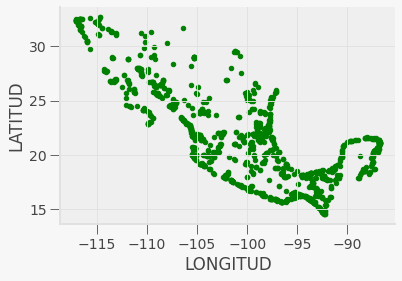

In [29]:
ndf_vd.plot.scatter('LONGITUD','LATITUD',c='green')

Para el caso del semáforo amarillo:

In [30]:
ndf_cal_am = ndf_vd.loc[:,['DBO_mg/L','DQO_mg/L','SST_mg/L','COLI_FEC_NMP_100mL','E_COLI_NMP_100mL','ENTEROC_NMP_100mL','OD_PORC','OD_PORC_SUP','OD_PORC_MED',
             'OD_PORC_FON','TOX_D_48_UT','TOX_V_15_UT','TOX_D_48_SUP_UT','TOX_FIS_SUP_15_UT']]
ndf_cal_am.describe(include='all')    

,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.0
mean,3.372192,18.241230,24.810056,281.205882,91.069853,18.582263,75.425573,82.649896,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
std,2.026717,5.873656,21.477673,180.914635,89.053108,26.784924,10.179535,18.192419,9.277570,14.945546,0.047670,0.053842,0.049476,0.0
min,2.000000,10.000000,10.000000,3.000000,3.000000,3.000000,34.800000,30.200000,35.200000,30.300000,1.000000,1.000000,1.000000,1.0
25%,2.000000,17.641000,10.000000,230.000000,41.000000,3.000000,75.425573,70.800000,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
50%,3.372192,18.241230,16.000000,281.205882,91.069853,18.582263,75.425573,82.649896,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
75%,3.372192,18.241230,31.660000,281.205882,91.069853,18.582263,75.425573,94.450000,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
max,21.500000,40.000000,147.000000,991.000000,750.000000,197.000000,129.600000,129.100000,124.300000,128.200000,2.699000,2.808000,2.390000,1.0


Con la comparación manual tenemos la siguiente escala para los amarillos:
*	DBO_mg/L		        Contaminada
* DQO_mg/L	       	  Contaminada
* SST_mg/L		        Contaminada
* COLI_FEC_NMP_100mL	Fuertemente contaminada
* E_COLI_NMP_100mL		Fuertemente contaminada
* ENTEROC_NMP_100mL		Fuertemente contaminada
*	OD_PORC		          Aceptable
*	OD_PORC_SUP		      Excelente
*	OD_PORC_MED	   	    Buena Calidad
*	OD_PORC_FON		      Buena Calidad
*	TOX_D_48_UT  		    Toxicidad Baja
*	TOX_V_15_UT	    	  Toxicidad moderada
*	TOX_D_48_SUP_UT	  	Toxicidad Baja
*	TOX_D_48_FON_UT		  NaN
*	TOX_FIS_SUP_15_UT		Toxicidad Baja
*	TOX_FIS_FON_15_UT	  NaN

In [31]:
for name in calidades:
  if name == 'CALIDAD_DBO':
    ndf_am[name] = ndf_am[name].astype('str')
    ndf_am[name] = ndf_am[name].replace('nan', 'Buena Calidad')
  if name == 'CALIDAD_DQO':
    ndf_am[name] = ndf_am[name].astype('str')
    ndf_am[name] = ndf_am[name].replace('nan', 'Buena Calidad') 
  if name == 'CALIDAD_SST':
    ndf_am[name] = ndf_am[name].astype('str')
    ndf_am[name] = ndf_am[name].replace('nan', 'Aceptable') 
  if name == 'CALIDAD_COLI_FEC':
    ndf_am[name] = ndf_am[name].astype('str')
    ndf_am[name] = ndf_am[name].replace('nan', 'Fuertemente contaminada') 
  if name == 'CALIDAD_E_COLI':
    ndf_am[name] = ndf_am[name].astype('str')
    ndf_am[name] = ndf_am[name].replace('nan', 'Fuertemente contaminada') 
  if name == 'CALIDAD_ENTEROC':
    ndf_am[name] = ndf_am[name].astype('str')
    ndf_am[name] = ndf_am[name].replace('nan', 'Excelente') 
  if name == 'CALIDAD_OD_PORC':
    ndf_am[name] = ndf_am[name].astype('str')
    ndf_am[name] = ndf_am[name].replace('nan', 'Excelente') 
  if name == 'CALIDAD_OD_PORC_SUP':
    ndf_am[name] = ndf_am[name].astype('str')
    ndf_am[name] = ndf_am[name].replace('nan', 'Excelente') 
  if name == 'CALIDAD_OD_PORC_MED':
    ndf_am[name] = ndf_am[name].astype('str')
    ndf_am[name] = ndf_am[name].replace('nan', 'Buena Calidad') 
  if name == 'CALIDAD_OD_PORC_FON':
    ndf_am[name] = ndf_am[name].astype('str')
    ndf_am[name] = ndf_am[name].replace('nan', 'Buena Calidad') 
  if name == 'CALIDAD_TOX_D_48':
    ndf_am[name] = ndf_am[name].astype('str')
    ndf_am[name] = ndf_am[name].replace('nan', 'Toxicidad Baja') 
  if name == 'CALIDAD_TOX_V_15':
    ndf_am[name] = ndf_am[name].astype('str')
    ndf_am[name] = ndf_am[name].replace('nan', 'Toxicidad Baja') 
  if name == 'CALIDAD TOX_D_48_SUP':
    ndf_am[name] = ndf_am[name].astype('str')
    ndf_am[name] = ndf_am[name].replace('nan', 'Toxicidad Baja') 
  if name == 'CALIDAD_TOX_FIS_SUP_15':
    ndf_am[name] = ndf_am[name].astype('str')
    ndf_am[name] = ndf_am[name].replace('nan', 'Toxicidad Baja') 

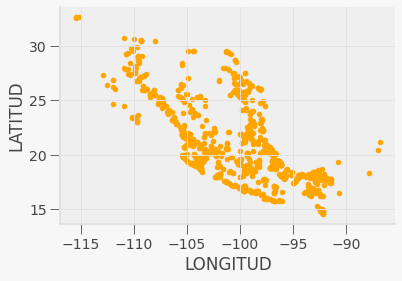

In [32]:
ndf_am.plot.scatter('LONGITUD','LATITUD',c='orange')

Para el caso del semáforo rojo:

In [33]:
ndf_cal_rj = ndf_vd.loc[:,['DBO_mg/L','DQO_mg/L','SST_mg/L','COLI_FEC_NMP_100mL','E_COLI_NMP_100mL','ENTEROC_NMP_100mL','OD_PORC','OD_PORC_SUP','OD_PORC_MED',
             'OD_PORC_FON','TOX_D_48_UT','TOX_V_15_UT','TOX_D_48_SUP_UT','TOX_FIS_SUP_15_UT']]
ndf_cal_rj.describe(include='all')  

,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.0
mean,3.372192,18.241230,24.810056,281.205882,91.069853,18.582263,75.425573,82.649896,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
std,2.026717,5.873656,21.477673,180.914635,89.053108,26.784924,10.179535,18.192419,9.277570,14.945546,0.047670,0.053842,0.049476,0.0
min,2.000000,10.000000,10.000000,3.000000,3.000000,3.000000,34.800000,30.200000,35.200000,30.300000,1.000000,1.000000,1.000000,1.0
25%,2.000000,17.641000,10.000000,230.000000,41.000000,3.000000,75.425573,70.800000,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
50%,3.372192,18.241230,16.000000,281.205882,91.069853,18.582263,75.425573,82.649896,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
75%,3.372192,18.241230,31.660000,281.205882,91.069853,18.582263,75.425573,94.450000,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
max,21.500000,40.000000,147.000000,991.000000,750.000000,197.000000,129.600000,129.100000,124.300000,128.200000,2.699000,2.808000,2.390000,1.0


Con la escala manual tenemos la siguiente escala para los rojos:
*	DBO_mg/L		       Buena Calidad
*	DQO_mg/L	         Buena Calidad
*	SST_mg/L		       Aceptable
*	COLI_FEC_NMP_100mL Fuertemente contaminada
*	E_COLI_NMP_100mL	 Fuertemente contaminada
*	ENTEROC_NMP_100mL	 Excelente
*	OD_PORC		         Excelente
*	OD_PORC_SUP		     Excelente
*	OD_PORC_MED		     Buena Calidad
*	OD_PORC_FON		     Buena Calidad
*	TOX_D_48_UT		     Toxicidad Baja
*	TOX_V_15_UT		     Toxicidad Baja
*	TOX_D_48_SUP_UT		 Toxicidad Baja
*	TOX_D_48_FON_UT		 NaN
*	TOX_FIS_SUP_15_UT	 Toxicidad Baja
*	TOX_FIS_FON_15_UT  NaN

In [34]:
for name in calidades:
  if name == 'CALIDAD_DBO':
    ndf_rj[name] = ndf_rj[name].astype('str')
    ndf_rj[name] = ndf_rj[name].replace('nan', 'Contaminada')
  if name == 'CALIDAD_DQO':
    ndf_rj[name] = ndf_rj[name].astype('str')
    ndf_rj[name] = ndf_rj[name].replace('nan', 'Contaminada') 
  if name == 'CALIDAD_SST':
    ndf_rj[name] = ndf_rj[name].astype('str')
    ndf_rj[name] = ndf_rj[name].replace('nan', 'Contaminada') 
  if name == 'CALIDAD_COLI_FEC':
    ndf_rj[name] = ndf_rj[name].astype('str')
    ndf_rj[name] = ndf_rj[name].replace('nan', 'Fuertemente contaminada') 
  if name == 'CALIDAD_E_COLI':
    ndf_rj[name] = ndf_rj[name].astype('str')
    ndf_rj[name] = ndf_rj[name].replace('nan', 'Fuertemente contaminada') 
  if name == 'CALIDAD_ENTEROC':
    ndf_rj[name] = ndf_rj[name].astype('str')
    ndf_rj[name] = ndf_rj[name].replace('nan', 'Fuertemente contaminada') 
  if name == 'CALIDAD_OD_PORC':
    ndf_rj[name] = ndf_rj[name].astype('str')
    ndf_rj[name] = ndf_rj[name].replace('nan', 'Aceptable') 
  if name == 'CALIDAD_OD_PORC_SUP':
    ndf_rj[name] = ndf_rj[name].astype('str')
    ndf_rj[name] = ndf_rj[name].replace('nan', 'Excelente') 
  if name == 'CALIDAD_OD_PORC_MED':
    ndf_rj[name] = ndf_rj[name].astype('str')
    ndf_rj[name] = ndf_rj[name].replace('nan', 'Buena Calidad') 
  if name == 'CALIDAD_OD_PORC_FON':
    ndf_rj[name] = ndf_rj[name].astype('str')
    ndf_rj[name] = ndf_rj[name].replace('nan', 'Buena Calidad') 
  if name == 'CALIDAD_TOX_D_48':
    ndf_rj[name] = ndf_rj[name].astype('str')
    ndf_rj[name] = ndf_rj[name].replace('nan', 'Toxicidad Baja') 
  if name == 'CALIDAD_TOX_V_15':
    ndf_rj[name] = ndf_rj[name].astype('str')
    ndf_rj[name] = ndf_rj[name].replace('nan', 'Toxicidad Moderada') 
  if name == 'CALIDAD TOX_D_48_SUP':
    ndf_rj[name] = ndf_rj[name].astype('str')
    ndf_rj[name] = ndf_rj[name].replace('nan', 'Toxicidad Baja') 
  if name == 'CALIDAD_TOX_FIS_SUP_15':
    ndf_rj[name] = ndf_rj[name].astype('str')
    ndf_rj[name] = ndf_rj[name].replace('nan', 'Toxicidad Baja') 

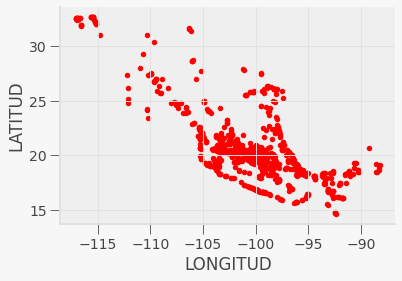

In [35]:
ndf_rj.plot.scatter('LONGITUD','LATITUD',c='red')

In [36]:
dfproc = pd.concat([ndf_vd, ndf_am, ndf_rj])

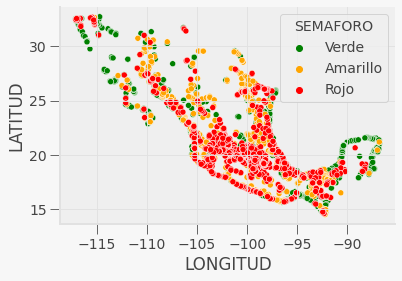

In [37]:
sns.scatterplot(data = dfproc, y="LATITUD", x="LONGITUD", hue="SEMAFORO", palette=['green','orange','red'])

In [38]:
dfproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 1 to 3490
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LONGITUD                3493 non-null   float64
 1   LATITUD                 3493 non-null   float64
 2   DBO_mg/L                3493 non-null   float64
 3   CALIDAD_DBO             3493 non-null   object 
 4   DQO_mg/L                3493 non-null   float64
 5   CALIDAD_DQO             3493 non-null   object 
 6   SST_mg/L                3493 non-null   float64
 7   CALIDAD_SST             3493 non-null   object 
 8   COLI_FEC_NMP_100mL      3493 non-null   float64
 9   CALIDAD_COLI_FEC        3493 non-null   object 
 10  E_COLI_NMP_100mL        3493 non-null   float64
 11  CALIDAD_E_COLI          3493 non-null   object 
 12  ENTEROC_NMP_100mL       3493 non-null   float64
 13  CALIDAD_ENTEROC         3493 non-null   object 
 14  OD_PORC                 3493 non-null   

In [39]:
ndf_cal_ver.describe(include='all')

,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.0
mean,3.372192,18.241230,24.810056,281.205882,91.069853,18.582263,75.425573,82.649896,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
std,2.026717,5.873656,21.477673,180.914635,89.053108,26.784924,10.179535,18.192419,9.277570,14.945546,0.047670,0.053842,0.049476,0.0
min,2.000000,10.000000,10.000000,3.000000,3.000000,3.000000,34.800000,30.200000,35.200000,30.300000,1.000000,1.000000,1.000000,1.0
25%,2.000000,17.641000,10.000000,230.000000,41.000000,3.000000,75.425573,70.800000,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
50%,3.372192,18.241230,16.000000,281.205882,91.069853,18.582263,75.425573,82.649896,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
75%,3.372192,18.241230,31.660000,281.205882,91.069853,18.582263,75.425573,94.450000,78.641516,74.517577,1.006513,1.009210,1.011264,1.0
max,21.500000,40.000000,147.000000,991.000000,750.000000,197.000000,129.600000,129.100000,124.300000,128.200000,2.699000,2.808000,2.390000,1.0


Con lo anterior nuestras variables se encuentran completas.

### **ENTREGA 2 Kmeans**

Vamos a seleccionar las variables independientes X y la variable dependiente Y (SEMAFORO)


In [40]:
X= pd.DataFrame(dfproc[["LONGITUD","LATITUD","DBO_mg/L","SST_mg/L","COLI_FEC_NMP_100mL","E_COLI_NMP_100mL","ENTEROC_NMP_100mL","OD_PORC","OD_PORC_SUP","OD_PORC_MED",
                    "OD_PORC_FON","TOX_D_48_UT","TOX_V_15_UT","TOX_D_48_SUP_UT","TOX_FIS_SUP_15_UT"]])
# esta se define después del label encoder y = pd.DataFrame(df[["SEMAFORO_Codigo"]])


Cambiemos el label encoding del semáforo

In [41]:
etiqueta_sem = LabelEncoder()
dfproc["SEMAFORO_Codigo"]= etiqueta_sem.fit_transform(dfproc["SEMAFORO"])
dfproc["SEMAFORO_Codigo"].unique()

array([2, 0, 1])

In [42]:
y = pd.DataFrame(dfproc[["SEMAFORO_Codigo"]])

In [43]:
dfproc[['SEMAFORO','SEMAFORO_Codigo']]

,SEMAFORO,SEMAFORO_Codigo
1,Verde,2
2,Verde,2
3,Verde,2
4,Verde,2
5,Verde,2
...,...,...
3479,Rojo,1
3481,Rojo,1
3483,Rojo,1
3489,Rojo,1


Realicemos el análisis general de las features importances a través de decision trees o random forest.

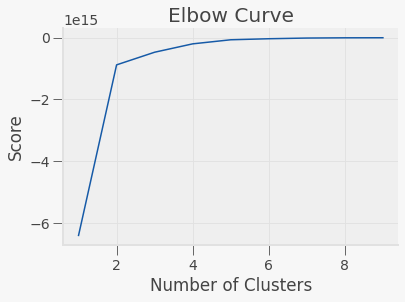

In [44]:
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [45]:
# Variables categoricas 
# categoricas = "CALIDAD_DBO","CALIDAD_SST","CALIDAD_COLI_FEC","CALIDAD_E_COLI","CALIDAD_ENTEROC","CALIDAD_OD_PORC","CALIDAD_OD_PORC_SUP","CALIDAD_OD_PORC_MED","CALIDAD_OD_PORC_FON","CALIDAD_TOX_D_48","CALIDAD_TOX_V_15","CALIDAD TOX_D_48_SUP","CALIDAD_TOX_FIS_SUP_15"

In [46]:
# El pipeline para variables contínuas
cont_pipe = Pipeline(steps=[('escalaNormal', StandardScaler())])
col_cont = ["LONGITUD","LATITUD","DBO_mg/L","SST_mg/L","COLI_FEC_NMP_100mL","E_COLI_NMP_100mL","ENTEROC_NMP_100mL","OD_PORC","OD_PORC_SUP","OD_PORC_MED","OD_PORC_FON","TOX_D_48_UT","TOX_V_15_UT","TOX_D_48_SUP_UT","TOX_FIS_SUP_15_UT"]

In [47]:
# Para las variables categoricas binarias
cat_bin = Pipeline(steps= [('bin', OneHotEncoder())])
cat_bin_col = ["CUMPLE_CON_DBO","CUMPLE_CON_DQO","CUMPLE_CON_SST","CUMPLE_CON_CF","CUMPLE_CON_E_COLI","CUMPLE_CON_ENTEROC","CUMPLE_CON_OD","CUMPLE_CON_TOX"]

In [48]:
transform_columns = ColumnTransformer(transformers=[
                                        ('var_cont', cont_pipe, col_cont),
                                        ('var_bin', cat_bin, cat_bin_col)])

In [49]:
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)
X_train.shape

(2794, 15)

In [50]:
y_train.shape

(2794, 1)

Seleccionamos las variables de mayor importancia.

Realizamos un clasificador, dividiendo los datos de manera balanceada, auxiliandonos de train test split.

Exploramos qué clasificador es el más óptimo:
* Decision trees.
* Random Forest.

Determinamos el grado de exactitud a través del reporte de clasificación:

Visualizamos los resultados del modelo o de las predicciones a través de una matriz de confusión.

Realizamos un reporte de los principales hallazgos y conclusiones del experimento y los incluimos en una presentación ejecutiva de 10 diapositivas. La presentación debe incluir todos los pasos del pipeline seguidos, limpieza, análisis, kmeans, clasificación, resultados y conclusiones.

['TOX_D_48_FON_UT','CALIDAD_TOX_D_48_FON','TOX_FIS_FON_15_UT','CALIDAD_TOX_FIS_FON_15']